## Сравнение точности (по метрике accuracy) в зависимости от разреженности сети при применении различных видов прунига

## Сравнение методов прунинга для ResNet18 на CIFAR-10

Проект исследует влияние различных методов прунинга на точность модели ResNet18 при классификации изображений CIFAR-10. Основная цель — определить, как степень разреженности весов модели влияет на её производительность в зависимости от выбранного метода прунинга.

## Особенности
- **Методы прунинга**:
  - Random Structured (случайное удаление структурных блоков).
  - Random Unstructured (случайное удаление отдельных весов).
  - Global Unstructured (удаление наименее значимых весов глобально).
  - L1 Structured (удаление каналов на основе нормы L1).
  - L1 Unstructured (удаление весов с наименьшими значениями L1).
- **Данные**: CIFAR-10 (10 классов, изображения 32x32).
- **Модель**: ResNet18, предобученная на CIFAR-10.
- **Метрики**: Точность (Accuracy), степень сжатия (процент удалённых параметров).
- **Визуализация**: Графики зависимости точности от уровня разреженности.


**Переобучение resnet18 на cifar10**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torchvision.models as models
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import copy
print(f"Done")

Done


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# 2. Загрузка и модификация ResNet18
def create_model():
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model.to(device)

In [ ]:
# 3. Загрузка данных CIFAR10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

100%|██████████| 170M/170M [00:03<00:00, 48.6MB/s]


**Прунинг**

In [ ]:
# 4. Функции для прунинга
def apply_l1_unstructured(model, amount=0.3):
    model = copy.deepcopy(model)  # обязательно!
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            prune.l1_unstructured(module, name='weight', amount=amount)
    return model

In [ ]:
def apply_global_unstructured(model, amount=0.3):
    model = copy.deepcopy(model)
    parameters_to_prune = [
        (module, 'weight') for name, module in model.named_modules()
        if isinstance(module, (nn.Conv2d, nn.Linear))
    ]
    prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=amount)
    return model

In [ ]:
def apply_structured_channel_pruning(model, amount=0.3):
    model = copy.deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)  # prune channels
        elif isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
    return model

In [ ]:
# 5. Функция оценки точности
def evaluate(model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    return correct / len(test_set)

In [ ]:
# 6. Функция подсчета оставшихся параметров
def count_nonzero_params(model):
    count = 0
    for module in model.modules():
        if hasattr(module, 'weight'):
            count += torch.count_nonzero(module.weight).item()
    return count

In [ ]:
# Добавим новые методы прунинга
def apply_random_unstructured(model, amount=0.3):
    model = copy.deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            prune.random_unstructured(module, name='weight', amount=amount)
    return model


In [ ]:
def apply_random_structured(model, amount=0.3):
    model = copy.deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.random_structured(module, name='weight', amount=amount, dim=0)  # prune channels
        elif isinstance(module, nn.Linear):
            prune.random_unstructured(module, name='weight', amount=amount)
    return model

In [ ]:
def run_experiment():
    results = []
    pruning_methods = {
        'L1 Unstructured': apply_l1_unstructured,
        'Global Unstructured': apply_global_unstructured,
        'Structured (Channels)': apply_structured_channel_pruning,
        'Random Unstructured': apply_random_unstructured,
        'Random Structured': apply_random_structured
    }

    sparsity_levels = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]

    # Базовая модель
    base_model = create_model()
    optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Предобучаем базовую модель
    base_model.train()
    for epoch in range(10):
        for inputs, labels in tqdm(train_loader, desc=f"Pre-training base model (Epoch {epoch+1}/5)"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = base_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    base_state_dict = copy.deepcopy(base_model.state_dict())
    original_params = count_nonzero_params(base_model)
    original_acc = evaluate(base_model)

    for name, prune_func in pruning_methods.items():
        for sparsity_level in sparsity_levels:
            print(f"\n=== Testing {name} at sparsity {sparsity_level:.0%} ===")

            model = create_model()
            model.load_state_dict(copy.deepcopy(base_state_dict))

            if sparsity_level == 0.0:
                pruned_model = model
                pruned_acc = original_acc
                remaining_params = original_params
                actual_sparsity = 0.0
                prune_time = 0.0
                inference_time = measure_inference_time(pruned_model)
            else:
                # Засекаем время прунинга
                start_time = time.time()
                pruned_model = prune_func(model, amount=sparsity_level)
                prune_time = time.time() - start_time

                # Засекаем время инференса
                inference_time = measure_inference_time(pruned_model)

                pruned_acc = evaluate(pruned_model)
                remaining_params = count_nonzero_params(pruned_model)
                actual_sparsity = 1 - (remaining_params / original_params)

            results.append({
                'Method': name,
                'Sparsity Level': sparsity_level,
                'Original Accuracy': original_acc,
                'Pruned Accuracy': pruned_acc,
                'Sparsity': actual_sparsity,
                'Remaining Params': remaining_params,
                'Prune Time (s)': prune_time,
                'Inference Time (s)': inference_time
            })

    # Вывод результатов
    print("\n=== Results ===")
    for res in results:
        print(f"{res['Method']} (target {res['Sparsity Level'] * 100:.0f}%):")
        print(f"  Original Acc: {res['Original Accuracy'] * 100:.2f}%")
        print(f"  Pruned Acc:   {res['Pruned Accuracy'] * 100:.2f}%")
        print(f"  Sparsity:     {res['Sparsity'] * 100:.2f}%")
        print(f"  Params Left:  {res['Remaining Params']:,}")
        print(f"  Prune Time:   {res['Prune Time (s)']:.4f} sec")
        print(f"  Inference Time: {res['Inference Time (s)']:.4f} sec\n")

    # График Sparsity vs Accuracy
    plt.figure(figsize=(12, 8))

    markers = ['o', 's', 'D', '^', 'v', '*']
    colors = plt.cm.tab10.colors

    methods = list(set(res['Method'] for res in results))
    for idx, method in enumerate(methods):
        method_results = [res for res in results if res['Method'] == method]
        sparsities = [res['Sparsity'] * 100 for res in method_results]
        accuracies = [res['Pruned Accuracy'] * 100 for res in method_results]
        plt.plot(sparsities, accuracies, marker=markers[idx % len(markers)], color=colors[idx % len(colors)],
                 label=method, linewidth=2)

    plt.title('Sparsity vs Pruned Accuracy', fontsize=16)
    plt.xlabel('Sparsity (%)', fontsize=14)
    plt.ylabel('Accuracy after Pruning (%)', fontsize=14)
    plt.legend(title="Pruning Method", fontsize=12, title_fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()

    # Сохраняем график в файл
    plt.savefig("sparsity_vs_accuracy.png", dpi=300, bbox_inches='tight')
    plt.show()

# Функция для измерения времени инференса
def measure_inference_time(model, runs=30):
    model.eval()
    dummy_input = next(iter(test_loader))[0].to(device)
    timings = []
    with torch.no_grad():
        # Прогрев
        for _ in range(5):
            model(dummy_input)
        # Засекаем время
        for _ in range(runs):
            start_time = time.time()
            model(dummy_input)
            end_time = time.time()
            timings.append(end_time - start_time)
    return sum(timings) / len(timings)

Pre-training base model (Epoch 10/5): 100%|██████████| 391/391 [00:17<00:00, 22.78it/s]



=== Testing L1 Unstructured at sparsity 0% ===

=== Testing L1 Unstructured at sparsity 10% ===

=== Testing L1 Unstructured at sparsity 30% ===

=== Testing L1 Unstructured at sparsity 50% ===

=== Testing L1 Unstructured at sparsity 70% ===

=== Testing L1 Unstructured at sparsity 90% ===

=== Testing Global Unstructured at sparsity 0% ===

=== Testing Global Unstructured at sparsity 10% ===

=== Testing Global Unstructured at sparsity 30% ===

=== Testing Global Unstructured at sparsity 50% ===

=== Testing Global Unstructured at sparsity 70% ===

=== Testing Global Unstructured at sparsity 90% ===

=== Testing Structured (Channels) at sparsity 0% ===

=== Testing Structured (Channels) at sparsity 10% ===

=== Testing Structured (Channels) at sparsity 30% ===

=== Testing Structured (Channels) at sparsity 50% ===

=== Testing Structured (Channels) at sparsity 70% ===

=== Testing Structured (Channels) at sparsity 90% ===

=== Testing Random Unstructured at sparsity 0% ===

=== Test

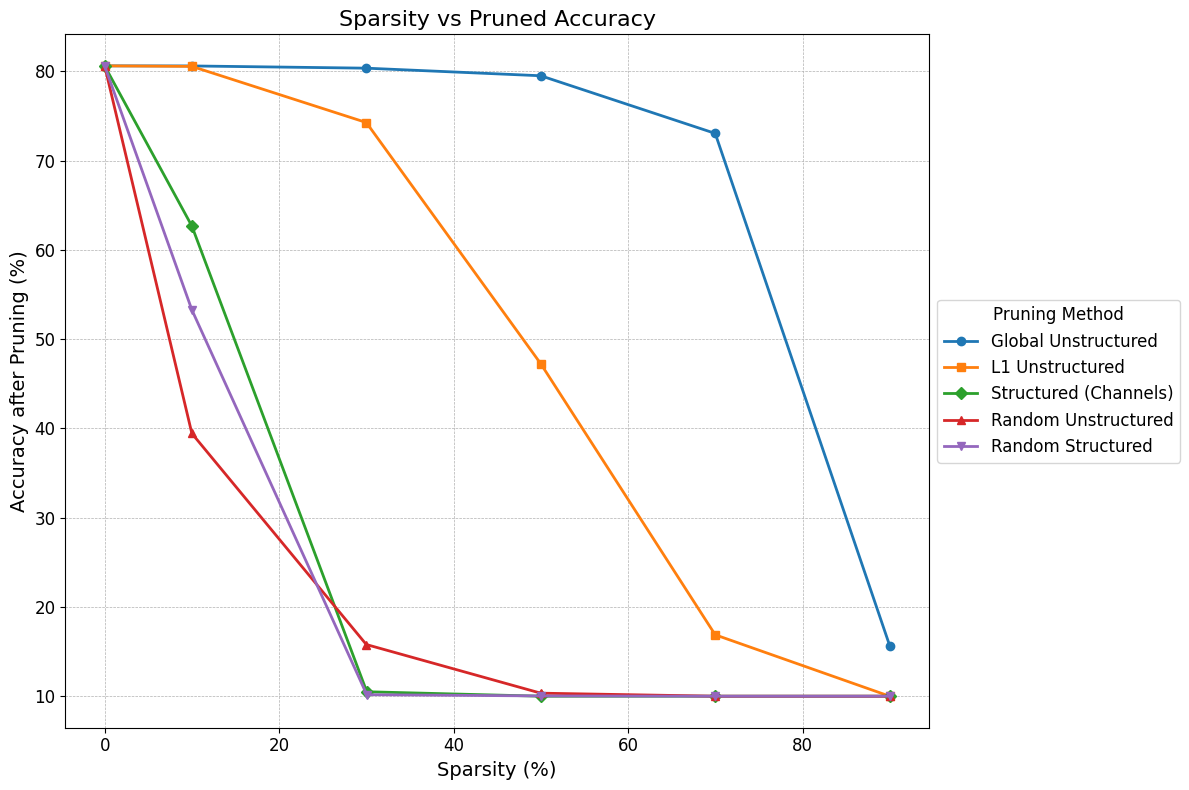

In [ ]:
if __name__ == "__main__":
    run_experiment()

Заметим, что наилучшие результаты продемонстрировали Global Unstructured и L1 Unstructured методы прунинга. 

Random Unstructured ожидаемо показал наихудшие результаты, так как является исключительно контрольным методом.

Структурные методы показали неудовлетворительные результаты, так как требуют дообучения, которое в этой работе не проводилось.